In [2]:
# Basics
import numpy as np
import os 

# Image Loading
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

# Evaluation
from sklearn import metrics

# Data preprocessing
from sklearn.preprocessing import normalize, StandardScaler

# Dimensionality Reduction
from sklearn.manifold import TSNE                   # 1) T-SNE
from sklearn.decomposition import PCA               # 2) PCA

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

Using TensorFlow backend.


In [3]:
## Data loading, and standardizing

trainData = "../Data/train" # 10k images //  96 x 96 x 3

new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(trainData, filename)) 
        new_train.append(np.asarray( image, dtype="uint8" ))
        image_names.append(filename)

meanMatrix = np.asarray(new_train)
X = meanMatrix.reshape((len(new_train),-1))
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [4]:
def ClusterAndPlot(n_clusters):
    HC = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='complete').fit(X)
    print('HC Silhouette Score  {} '.format(metrics.silhouette_score(X, HC.labels_)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(X, kmeans.labels_)))

    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X)
    gmmlabels_ = gmm.predict(X)
    print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(X, gmmlabels_)))
    
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    axs[0, 0].scatter(X[:, 0], X[:, 1], cmap='viridis');
    axs[0, 0].set_title('Normal')

    axs[0, 1].scatter(X[:, 0], X[:, 1], c=gmmlabels_, cmap='viridis');
    axs[0, 1].set_title('GMM')

    axs[1, 0].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis');
    axs[1, 0].set_title('K-Means')

    axs[1, 1].scatter(X[:, 0], X[:, 1], c=HC.labels_, cmap='viridis');
    axs[1, 1].set_title('HC')
    plt.show()
    
    return [HC.labels_, kmeans.labels_, gmmlabels_]


In [5]:
n_images = X.shape[0]
X.shape

(9999, 27648)

In [6]:
# Step 3: Reduce the full dimensional space using autoencoders -> Cluster
meanMatrix.shape

(9999, 96, 96, 3)

In [7]:
autoencoder = load_model('Autoencoders/SavedModels/autoencoder_train_epochs100_batch32_best.h5')
autoencoder.summary()

W0104 23:18:44.169819 4321239936 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0104 23:18:47.503393 4321239936 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 48, 48, 64)        1849

(9999, 6, 6, 32)


Text(0.5, 1.0, 'Normal')

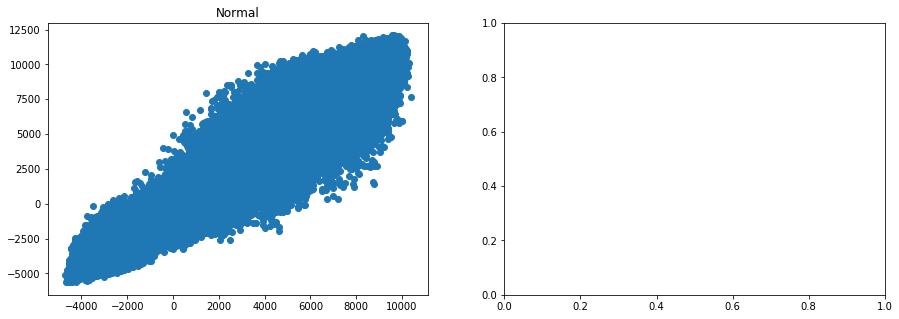

In [8]:
layer_name = 'conv2d_30'
intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

X = intermediate_layer_model.predict(meanMatrix)
print(X.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[0].set_title('Normal')

X = X.reshape((n_images, -1))
print(X.shape)
axs[1].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[1].set_title('Normal Reshaped')

In [13]:
decoded_imgs = intermediate_layer_model.predict(meanMatrix)
# X[0].shape.reshape((-1,-1,3))
decoded_imgs.shape

(9999, 6, 6, 32)

In [ ]:
labels = ClusterAndPlot(4)

HC Silhouette Score  0.2680744528770447 
kmeans Silhouette Score  0.29120633006095886 


In [12]:
X.shape

(9999, 1152)

In [20]:
def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

def clusterintoDirectories(labels):
    directory = trainData
    sub_directories = [str(cluster) for cluster in set(labels)]

    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(directory + '/{}'.format(cluster) , exist_ok=True)

    for i in range(len(image_names)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if image_names[i] not in os.listdir(directory + '/' + sub_directories[labels[i]]): 
            symlink_rel(directory + '/{}'.format(image_names[i]) , 
                       directory + '/{}'.format(labels[i]) + '/' + image_names[i])

HC = AgglomerativeClustering(n_clusters=10, affinity='manhattan', linkage='complete').fit(X)
clusterintoDirectories(HC.labels_)
# clusterintoDirectories(kmeans.labels_)
# clusterintoDirectories(gmmlabels_)